In [1]:
import nb_utils
import os
import pickle
import torch
import nb_utils
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
from models.fcn import FCN
import pickle
import sde_lib
from dim_reduction import get_manifold_dimension

Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


/store/CIA/js2164/conda_envs/score_sde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path ='logs/ksphere/robustness/std=0.0/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
#config.model.checkpoint_path = $os.path.join(log_path, log_name, "checkpoints/best/last.ckpt")
config.model.checkpoint_path = 'logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt'

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config.training.batch_size=32
config.dim_estimation.num_datapoints=5

In [3]:
import torch 
from pathlib import Path
import os
from lightning_modules.utils import create_lightning_module
from lightning_data_modules.utils import create_lightning_datamodule
from models import utils as mutils
import math
from tqdm import tqdm
import pickle

#---- create the setup ---
def robust(config, noise=0):
  log_path = config.logging.log_path
  log_name = config.logging.log_name
  save_path = os.path.join(log_path, log_name, 'svd')
  Path(save_path).mkdir(parents=True, exist_ok=True)

  DataModule = create_lightning_datamodule(config)
  DataModule.setup()
  train_dataloader = DataModule.train_dataloader()
    
  pl_module = create_lightning_module(config)
  pl_module = pl_module.load_from_checkpoint(config.model.checkpoint_path)
  pl_module.configure_sde(config)

  #get the ema parameters for evaluation
  #pl_module.ema.store(pl_module.parameters())
  #pl_module.ema.copy_to(pl_module.parameters()) 

  device = config.device
  pl_module = pl_module.to(device)
  pl_module.eval()
  
  score_model = pl_module.score_model
  sde = pl_module.sde
  score_fn = mutils.get_score_fn(sde, score_model, conditional=False, train=False, continuous=True)
  #---- end of setup ----

  num_datapoints = 100
  singular_values = []
  normalized_scores_list = []
  idx = 0
  with tqdm(total=num_datapoints) as pbar:
    for _, orig_batch in enumerate(train_dataloader):

      orig_batch = orig_batch.to(device)
      batchsize = orig_batch.size(0)
      
      if idx+1 >= num_datapoints:
          break
        
      for x in orig_batch:
        if idx+1 >= num_datapoints:
          break
        
        ambient_dim = math.prod(x.shape[1:])
        x = x.repeat([batchsize,]+[1 for i in range(len(x.shape))])

        num_batches = ambient_dim // batchsize + 1
        extra_in_last_batch = ambient_dim - (ambient_dim // batchsize) * batchsize
        num_batches *= 8

        t = pl_module.sampling_eps
        vec_t = torch.ones(x.size(0), device=device) * t

        scores = []
        for i in range(1, num_batches+1):
          batch = x.clone()

          mean, std = sde.marginal_prob(batch, vec_t)
          z = torch.randn_like(batch)
          batch = mean + std[(...,) + (None,) * len(batch.shape[1:])] * z
          score = score_fn(batch, vec_t).detach().cpu()

          if i < num_batches:
            scores.append(score)
          else:
            scores.append(score[:extra_in_last_batch])
        
        scores = torch.cat(scores, dim=0)
        scores = torch.flatten(scores, start_dim=1)

        means = scores.mean(dim=0, keepdim=True)
        normalized_scores = scores - means
        #print(normalized_scores.shape)
        #corrupt
        norm = torch.linalg.norm(normalized_scores, dim=1).mean()
        corruption = noise * norm * torch.randn_like(normalized_scores) / np.sqrt(normalized_scores.shape[1])
        corruption_norm = torch.linalg.norm(corruption, dim=1).mean()
        
        normalized_scores = corruption + normalized_scores
        
        #normalized_scores_list.append(normalized_scores.tolist())

        u, s, v = torch.linalg.svd(normalized_scores)
        s = s.tolist()
        singular_values.append(s)

        idx+=1
        pbar.update(1)
    print(f'score norm: {norm}, corruption norm: {corruption_norm}, corruption_std: {noise * norm / np.sqrt(normalized_scores.shape[1])}')
    return singular_values

In [4]:
stds = np.linspace(0, 1, 6)
r = []
for std in stds:
    singular_values = robust(config, noise=std)
    r.append(singular_values)

Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 56.42it/s]


score norm: 77382.9140625, corruption norm: 0.0, corruption_std: 0.0


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 88.05it/s] 


score norm: 76625.2265625, corruption norm: 15291.3134765625, corruption_std: 1532.504638671875


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 87.03it/s] 


score norm: 77544.0859375, corruption norm: 30996.82421875, corruption_std: 3101.763427734375


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 87.63it/s] 


score norm: 77068.921875, corruption norm: 45983.91015625, corruption_std: 4624.1357421875


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 84.65it/s] 


score norm: 77389.609375, corruption norm: 62565.59375, corruption_std: 6191.1689453125


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 99%|█████████▉| 99/100 [00:01<00:00, 83.81it/s] 

score norm: 77839.671875, corruption norm: 77661.78125, corruption_std: 7783.96728515625


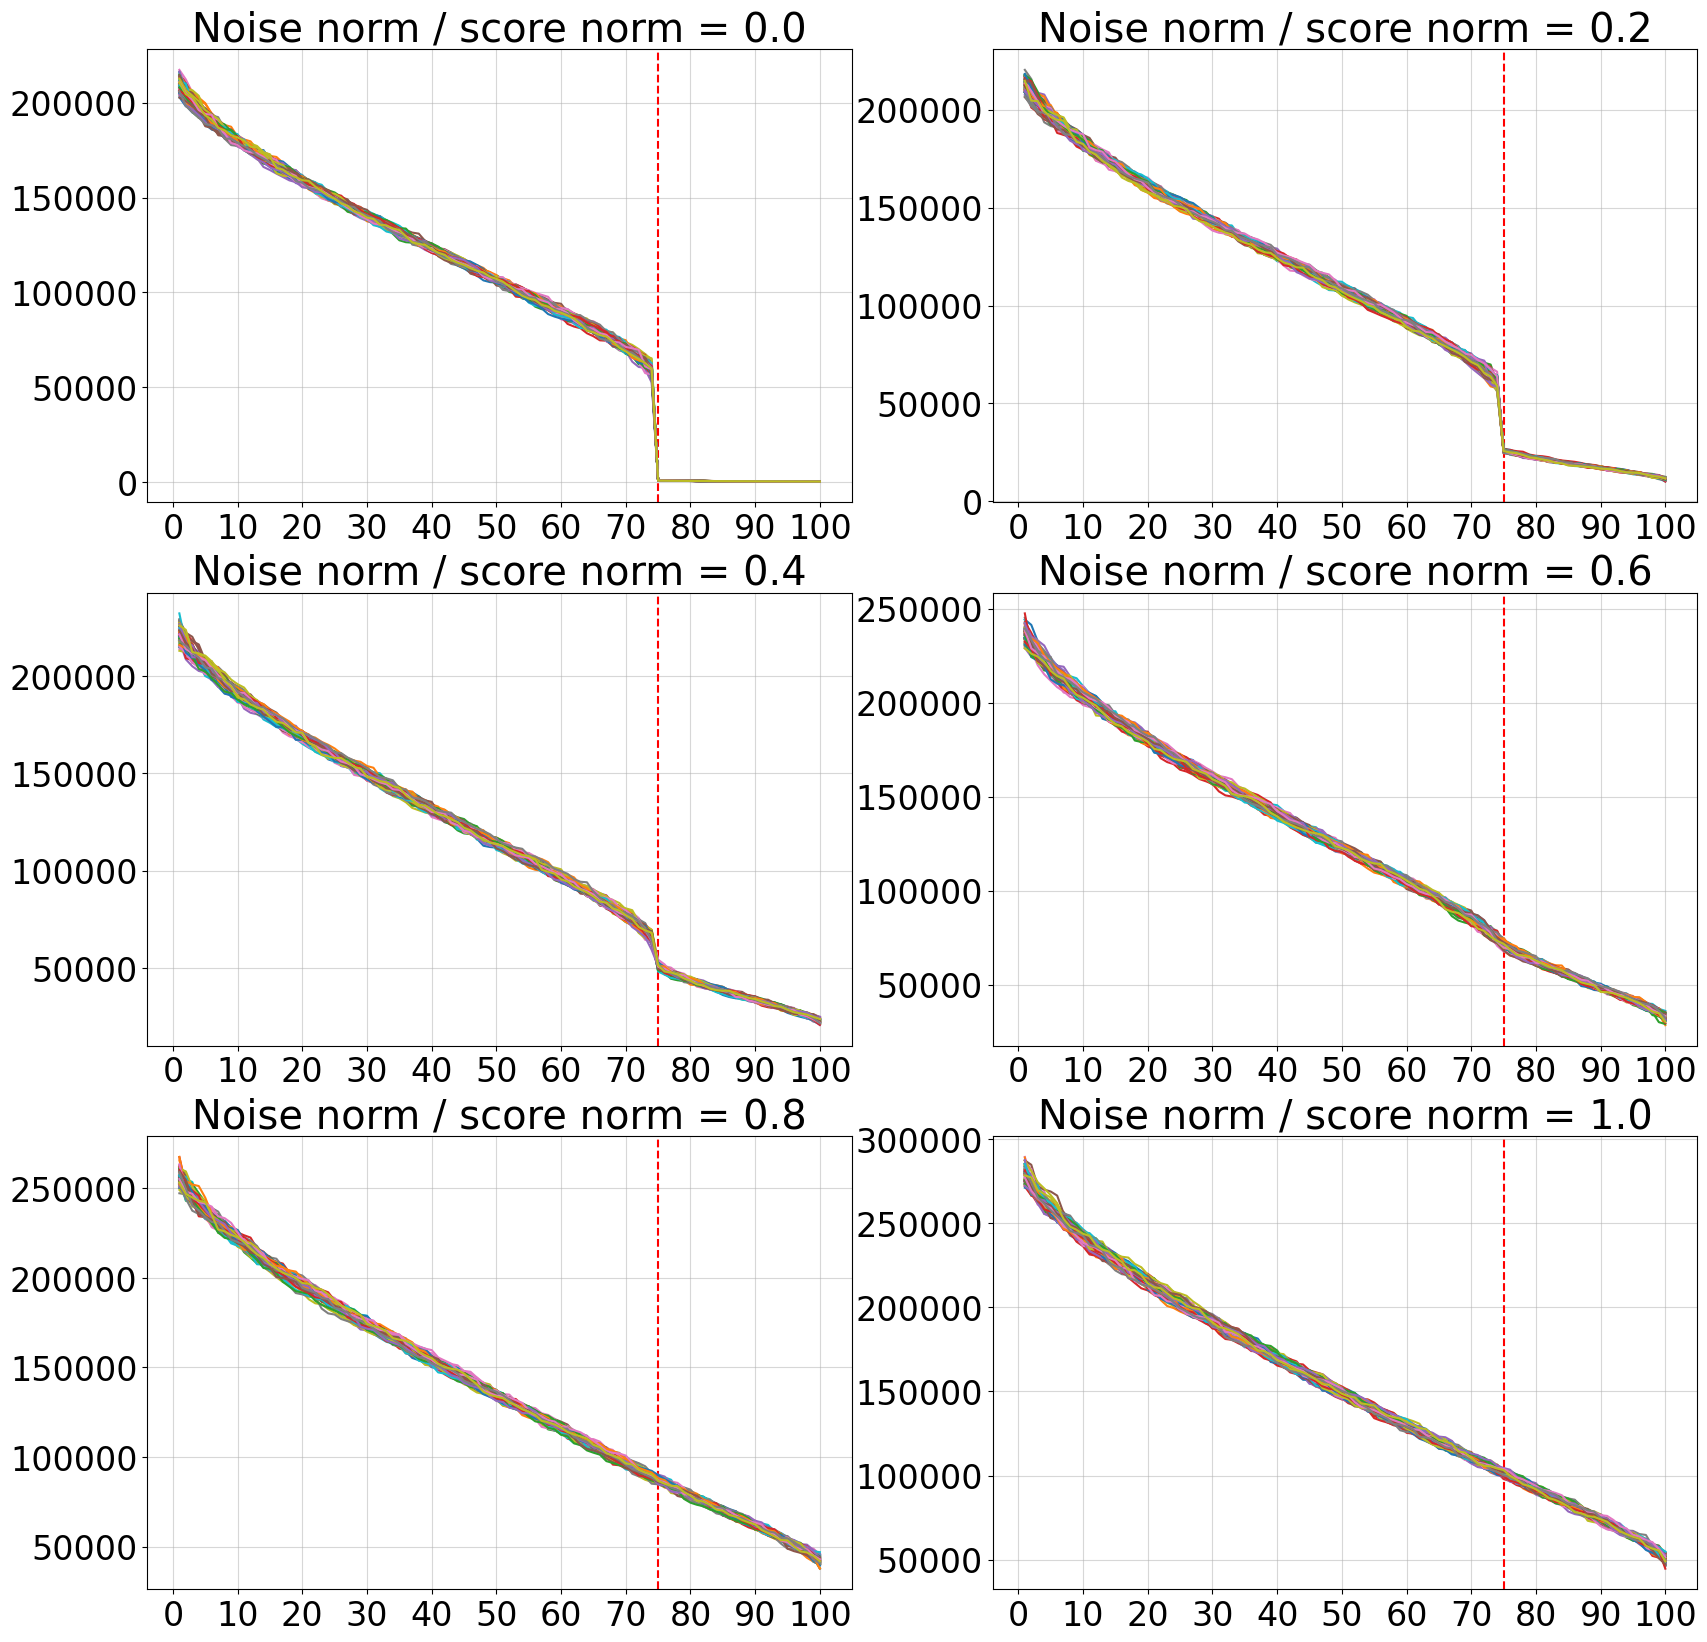

In [9]:
plt.rcParams.update({'font.size': 24})
fig, axes = plt.subplots(3, 2,figsize=(20,20))
axes = axes.flatten()
#ax.rcParams.update({'font.size': 16})

ground_truth = 25
for i, (std, singular_values) in enumerate(zip(stds, r)):
    sing_vals = singular_values[0]
    axes[i].grid(alpha=0.5)
    axes[i].set_title(f'Noise norm / score norm = {std:.2}')
    axes[i].set_xticks(np.arange(0, len(sing_vals)+1, 10))
    axes[i].axvline(x=len(sing_vals)-ground_truth, color='red', ls='--')
    for sing_vals in singular_values:
        #axes[i].bar(list(range(1, len(sing_vals)+1)),sing_vals)
        axes[i].plot(list(range(1, len(sing_vals)+1)),sing_vals)
    #axes[i].legend()
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
#fig.suptitle('25-Sphere in 100 dimensions', fontsize=40)
fig.show()
fig.savefig(f'figures/paper/robustness_score.png', bbox_inches='tight', dpi=300, facecolor='w')

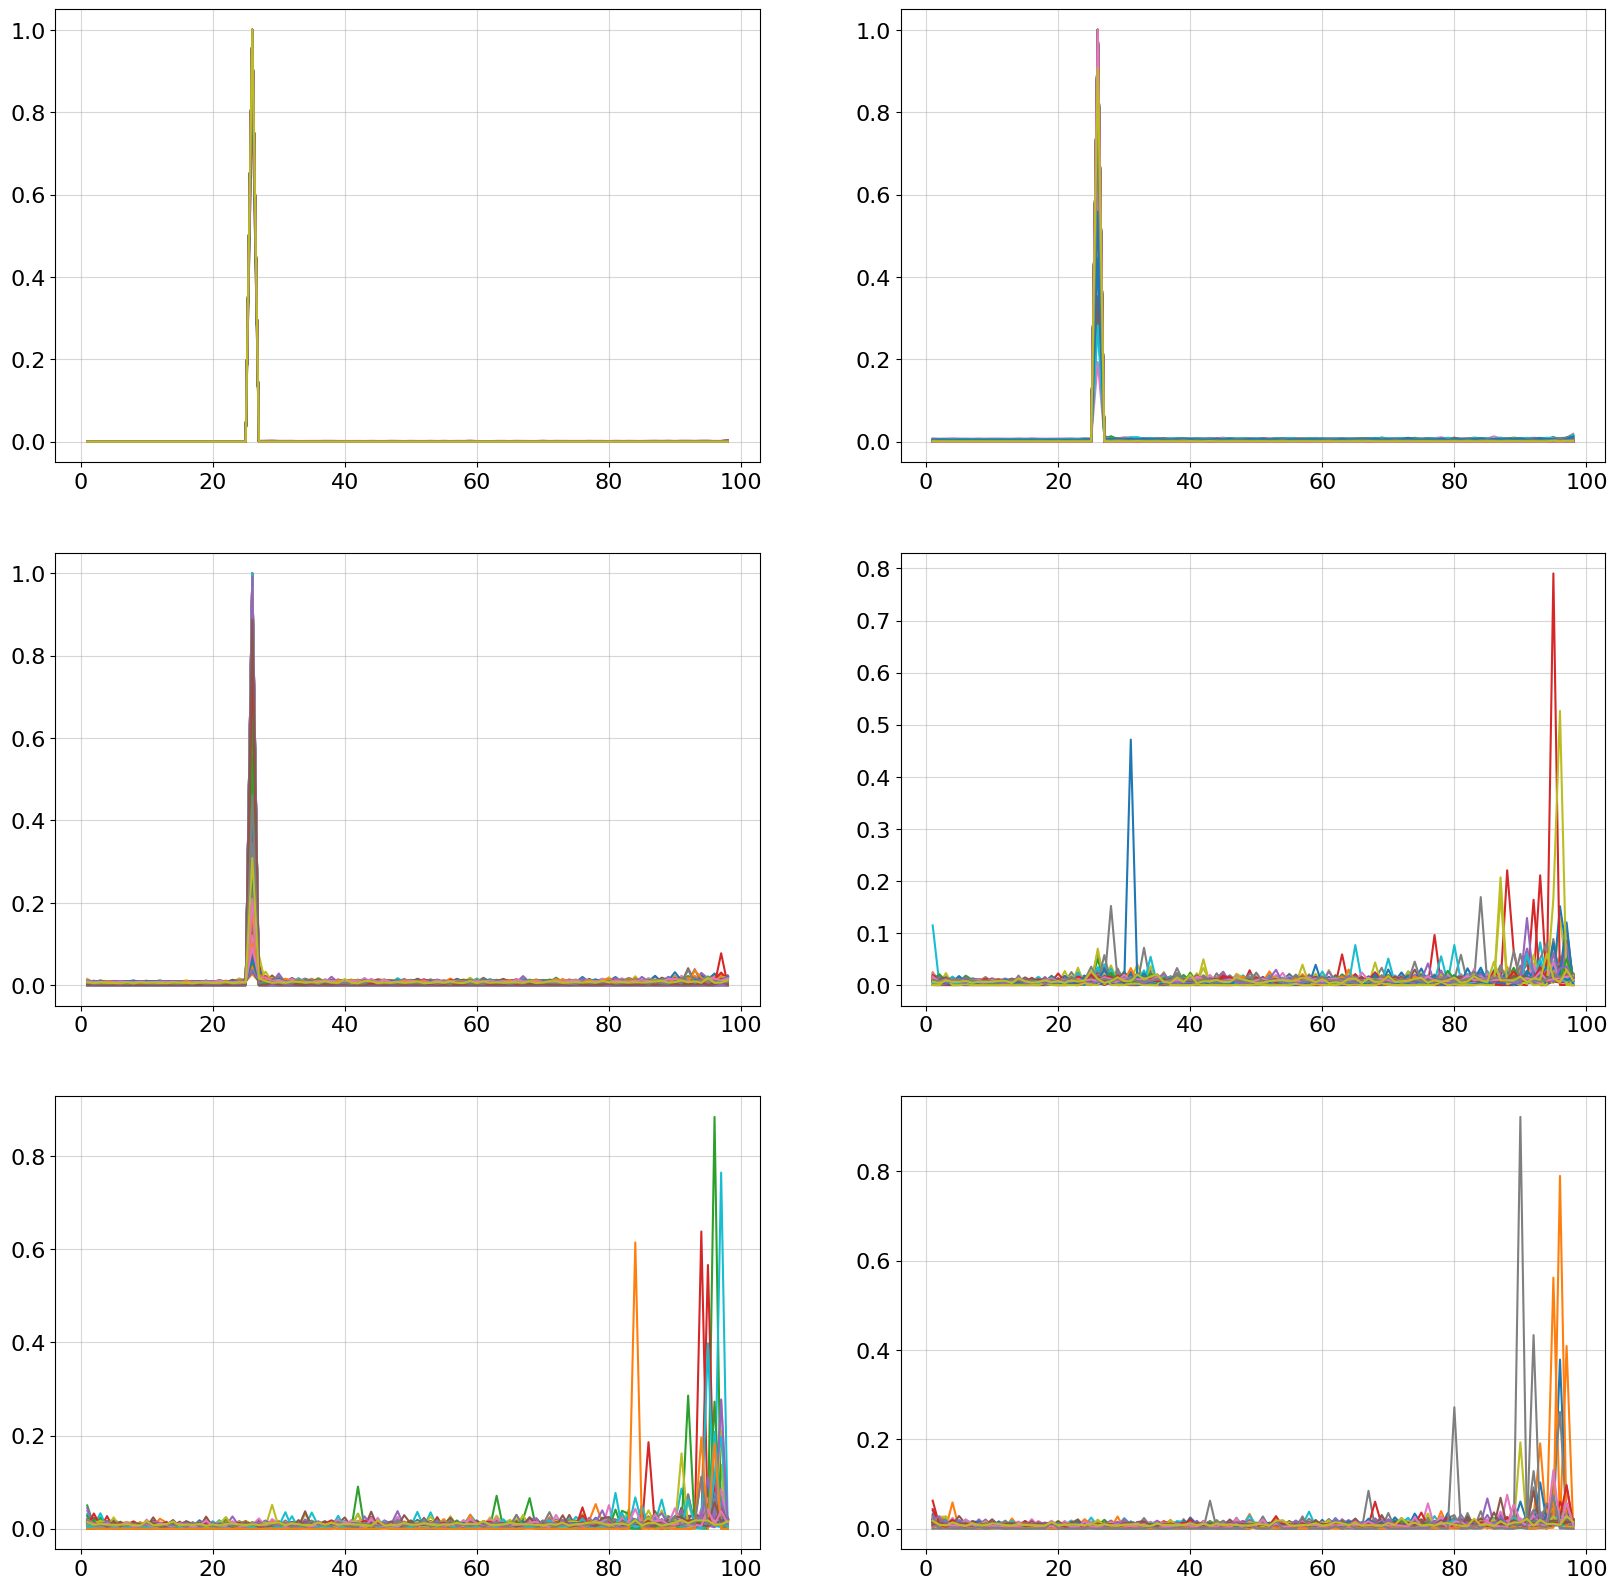

In [35]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference
    

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(3, 2,figsize=(20,20))
axes = axes.flatten()    
for i, (std, singular_values) in enumerate(zip(stds, r)):
    sing_vals = singular_values[0]
    
    axes[i].grid(alpha=0.5)
    #axes[i].title('Dimension distribution')
    dims=[]
    for sing_vals in singular_values:
        s=sing_vals
        norm_factor = s[1]-s[2]
        diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
        soft = softmax(diff)
        axes[i].plot(list(range(1,1+len(soft)))[::-1],soft)
        #plt.xticks(np.arange(0, len(sing_vals)+1, 10))
        dim = len(soft)-soft.argmax()
        dims.append(dim)

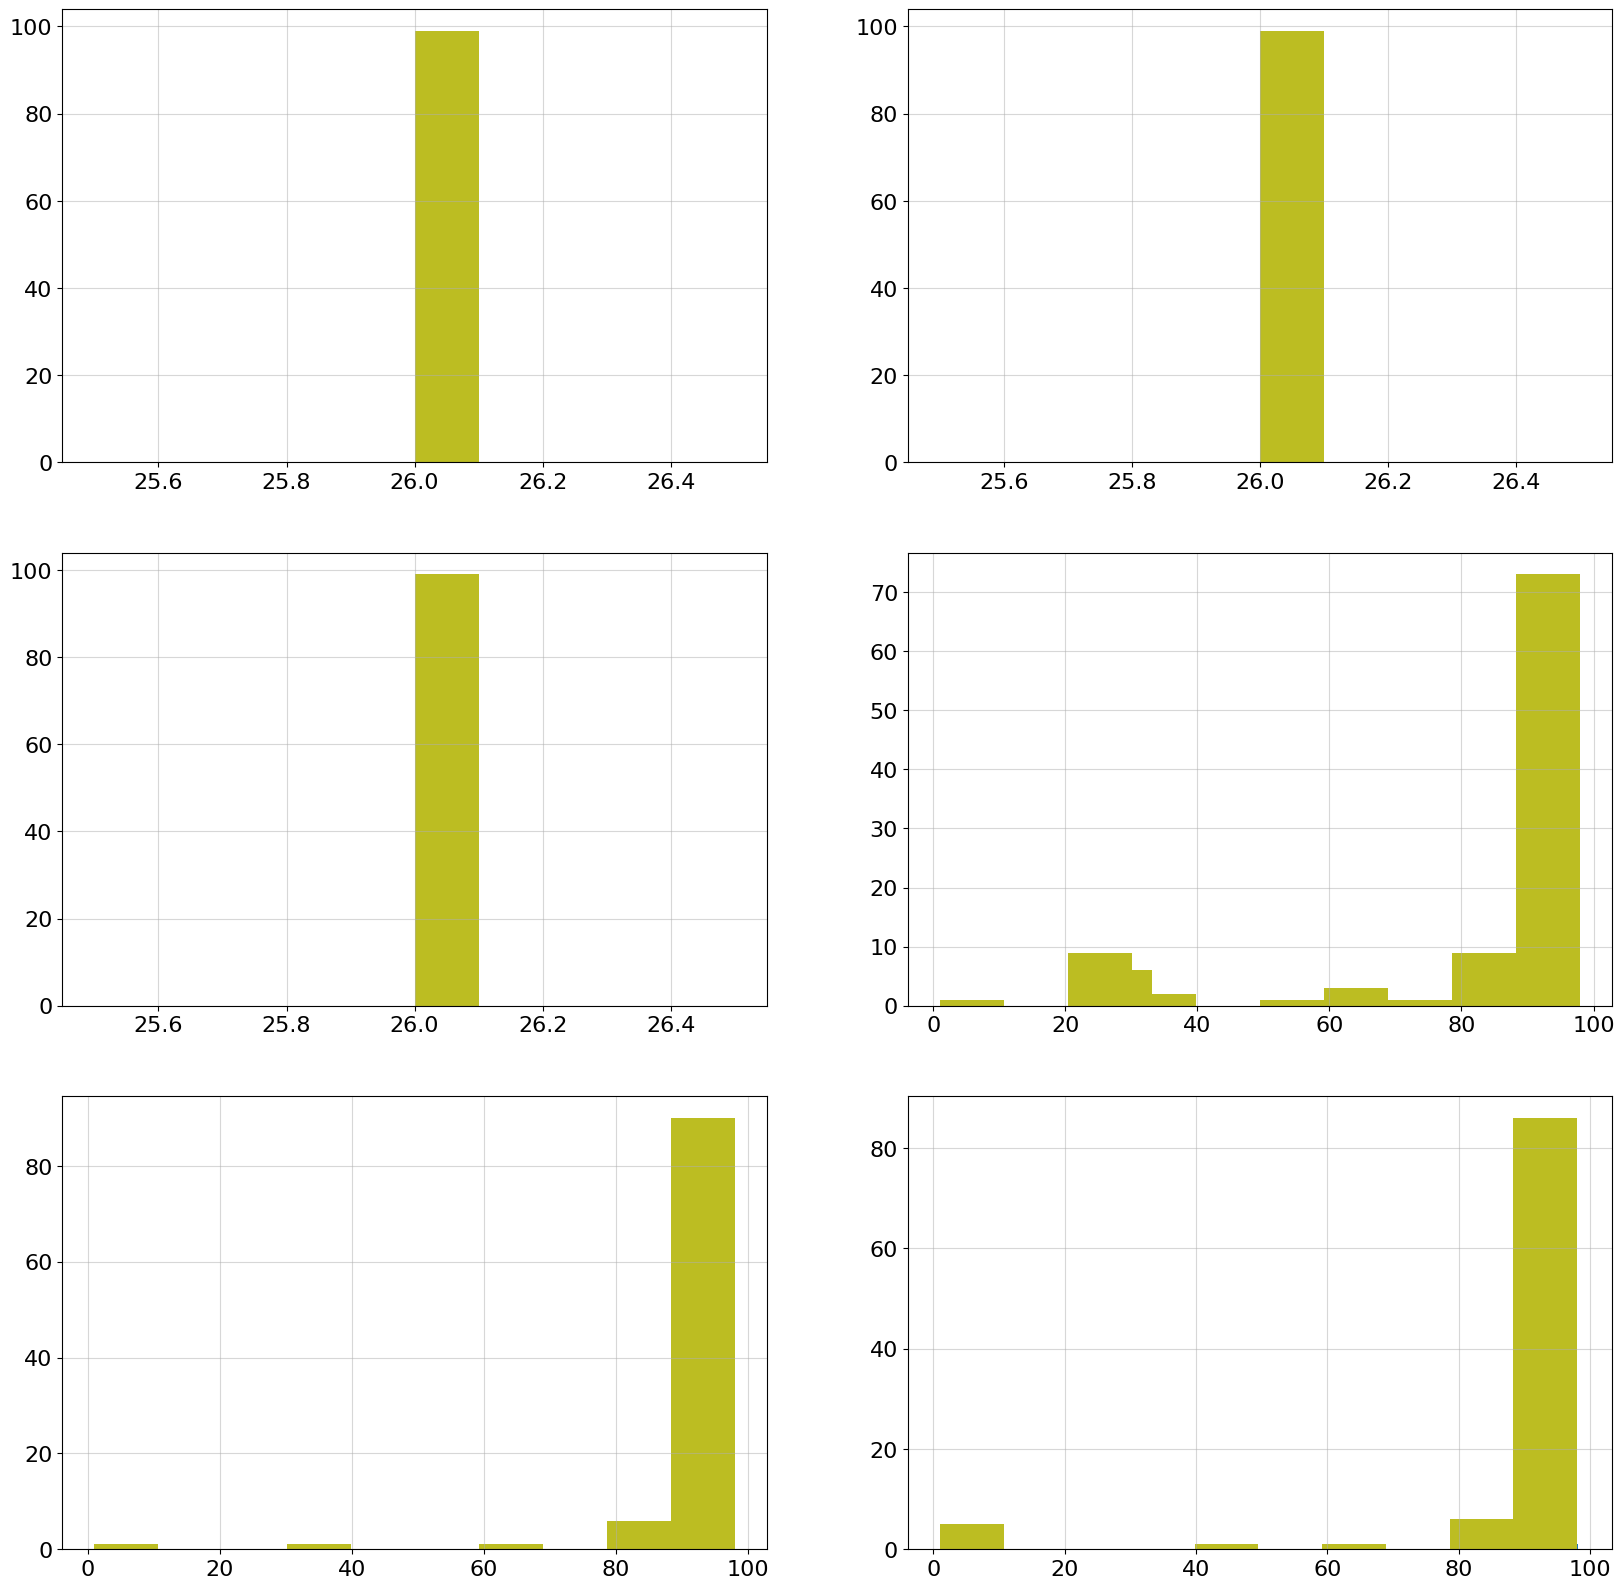

In [37]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference
    

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(3, 2,figsize=(20,20))
axes = axes.flatten()    
for i, (std, singular_values) in enumerate(zip(stds, r)):
    sing_vals = singular_values[0]
    
    axes[i].grid(alpha=0.5)
    #axes[i].title('Dimension distribution')
    dims=[]
    for sing_vals in singular_values:
        s=sing_vals
        norm_factor = s[1]-s[2]
        diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
        soft = softmax(diff)
        
        #plt.xticks(np.arange(0, len(sing_vals)+1, 10))
        dim = len(soft)-soft.argmax()
        dims.append(dim)
        axes[i].hist(dims)

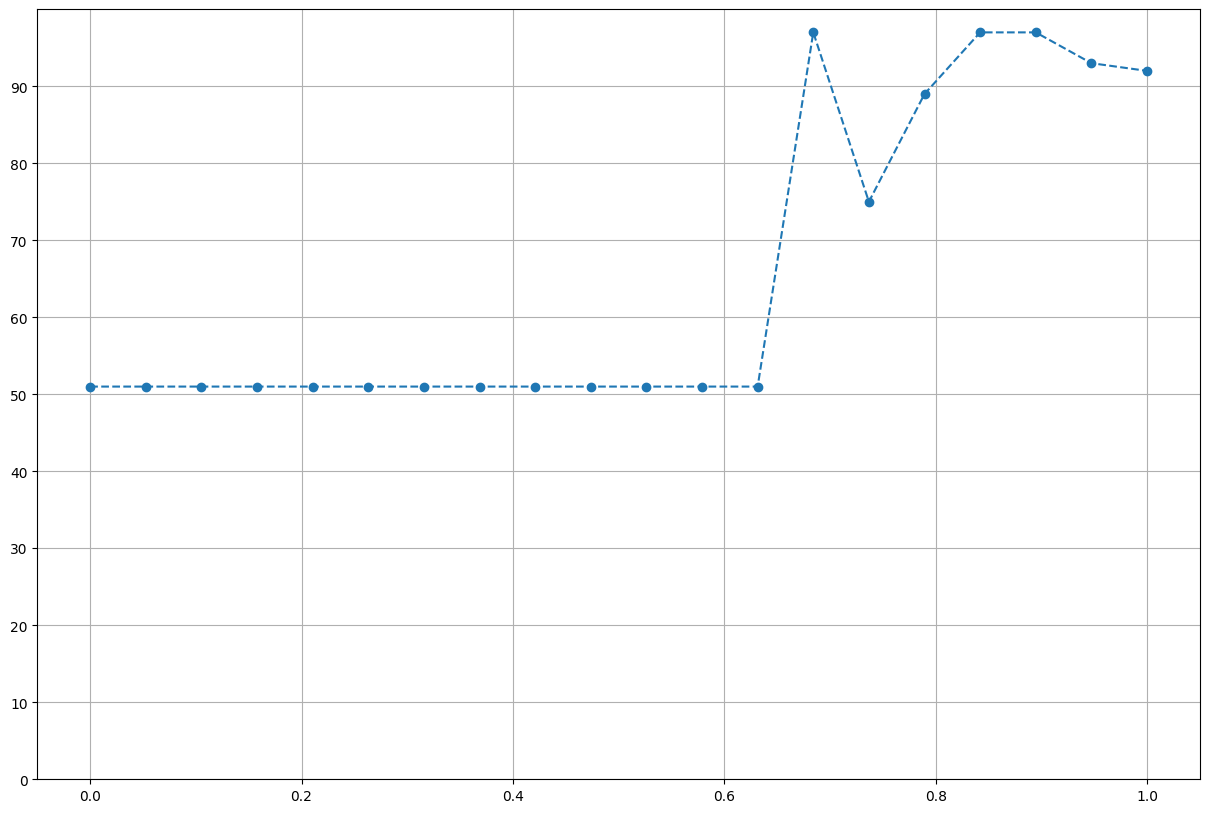

In [19]:
plt.figure(figsize=(15,10))
plt.plot(stds, dims, 'o--')
plt.ylim(0,100)
plt.yticks(range(0,100,10))
plt.grid()